# Chapter 8


*	Changes over time in ideological distance from the parties by authoritarianism. This primarily consists of two figures, Figures 1 and 2.

*	Asymmetric effects of ideological proximity to parties on voting as a function of authoritarianism (Figures 3 and 4). This is the spatial analysis, with associated contour plots.

*	Authoritarianism predicts presidential voting more among those who perceive greater partisan polarization (Figures 5-6)

These three portions of the chapter form a cohesive unit and they focus very precisely on questions of ideological proximity and perceived ideological polarization. 

### Load Data

Below I load the data and dependencies. I also create a few variables that will be used in the analysis.


In [ ]:
rm(list = ls())
library(brms)
library(modelr)
library(dplyr)
library(modelr)
library(tidybayes)
library(haven)
library(ggplot2)
library(dplyr)
library(cowplot)

load ("~/ch8models..rda")
load("~/spatialModel.rda")
source("functions/common_functions.r")

# Update ggplot persistent theme

ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
  axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  strip.text.x = element_text(size = 16),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 14),
  legend.title = element_text(size = 16)
)

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


`summarise()` has grouped output by 'authoritarianism'. You can override using
the `.groups` argument.


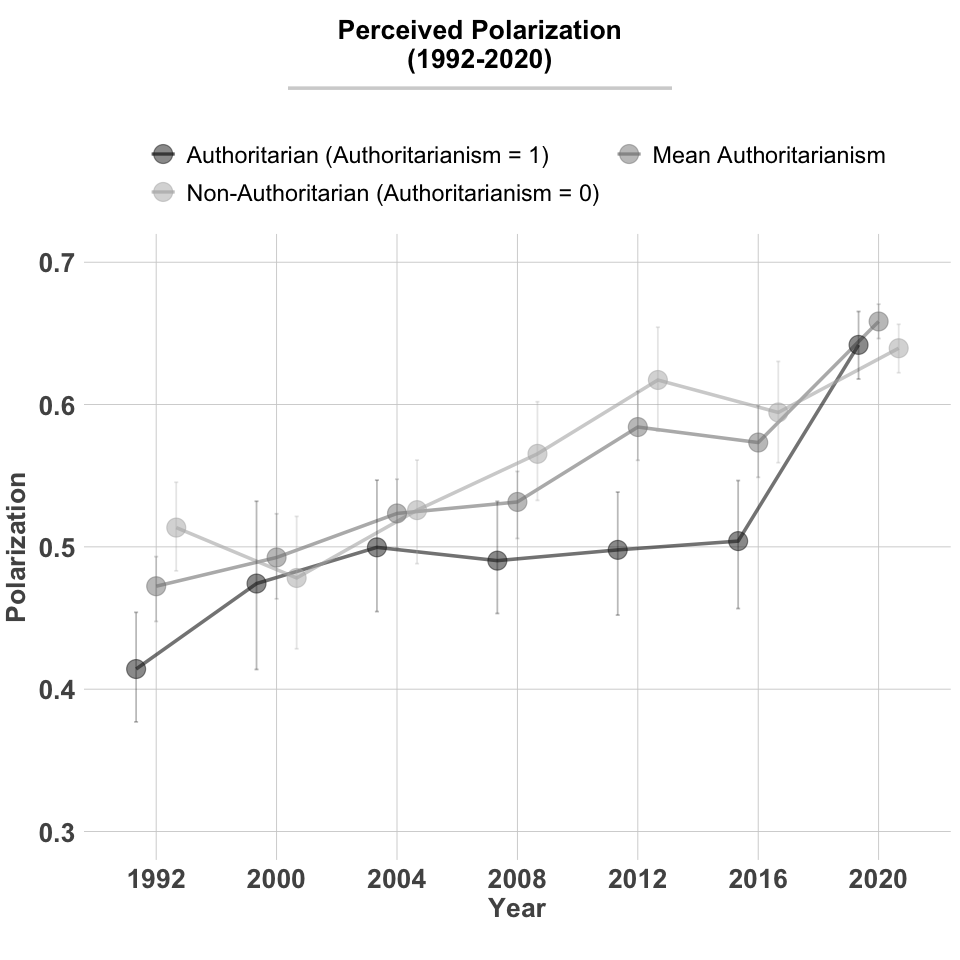

In [ ]:
options(repr.plot.width = 10,  repr.plot.height = 5)

average_data = ch8models[[1]] %>%
  select(authoritarianism, female, age, college, income, jewish, catholic, other, year) %>%
  na.omit() %>%
  group_by(year) %>% data_grid(female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), authoritarianism = mean(authoritarianism)) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(ch8models[["polarization"]])  %>%
  group_by(year) %>%
  summarize(
    min = quantile(.epred, 0.025),
    med = quantile(.epred, 0.50),
    max = quantile(.epred, 0.975)) %>%
  mutate(authoritarianism = "Mean Authoritarianism")

disagg_data <- ch8models[[1]] %>%
  select( authoritarianism, female, age, college, income, jewish, catholic, other, year) %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), authoritarianism = seq_range(authoritarianism, 2)) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(ch8models[["polarization"]]) %>%
  group_by(authoritarianism, year) %>%
  summarize(
    min = quantile(.epred, 0.025),
    med = quantile(.epred, 0.50),
    max = quantile(.epred, 0.975)) %>%
    mutate(authoritarianism = ifelse(authoritarianism == 1, "Authoritarian (Authoritarianism = 1)", "Non-Authoritarian (Authoritarianism = 0)") )
    # Remove the authorirarianism column

rbind(average_data, disagg_data) %>%
  # Reorder the authoritarianism variable
  mutate(authoritarianism = factor(authoritarianism, levels = c("Authoritarian (Authoritarianism = 1)", "Mean Authoritarianism", "Non-Authoritarian (Authoritarianism = 0)"))) %>%
  ggplot(aes(color = authoritarianism, x = factor(year), y = med, ymin = min, ymax = max, group = authoritarianism)) +
  # facet_wrap(~ authoritarianism, ncol =1) +
  geom_line(size = 1, alpha = 0.60, position = position_dodge(width = 0.5)) +
  geom_point(size = 5, alpha = 0.50, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.3, position = position_dodge(width = 0.5)) +
  #Change legend
  ggtitle("") +
  # Add a subtitle
  ylab("Polarization") +
  xlab("Year") +
  ggtheme +
  # Change the y axis limits from 0 to 0.8
  scale_y_continuous(limits = c(.3, 0.7)) +
  # Add a caption
  # Align the caption to the left
  theme(plot.caption = element_text(hjust = 0)) +
  # Make the title smaller, and the second line should be smaller than the first
  theme(plot.title = element_text(size = 16, lineheight = 0.9)) +
  # Change the colors to gradations of grey
  scale_color_grey(start = 0.1, end = 0.7) +
  theme(legend.position = "top")  +
  # remove legend title
  theme(legend.title = element_blank()) +
   guides(color = guide_legend(nrow = 2, byrow = TRUE)) -> p1


# Combine the plots
combined_plot <- plot_grid(p1, NULL, ncol = 1, rel_heights = c(1.5, 0.05, 0.8))

# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
  draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
  draw_label("Perceived Polarization\n(1992-2020)", fontface = "bold", size = 16, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
  ncol = 1,
  rel_heights = c(0.1, 1)
)


options(repr.plot.width = 8, repr.plot.height = 8)
final_plot


In [40]:
ch8models[["polarization"]]$data %>% dim()

[1] 6873   11

In [309]:
# Predictions
ch8models[["filteredData"]]  %>%
  select( authoritarianism, female, age, college, income, jewish, catholic, other, year) %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), authoritarianism = seq_range(authoritarianism, n = 2)) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch8models[["polarization"]] ) %>% summarize(
    mean(.linpred)
  )

`summarise()` has grouped output by 'year', 'female', 'age', 'college',
'income', 'catholic', 'jewish', 'other', 'authoritarianism',
'authoritarianism2'. You can override using the `.groups` argument.


year,female,age,college,income,catholic,jewish,other,authoritarianism,authoritarianism2,.row,mean(.linpred)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1992,0.4868571,0.3773571,0.3211429,0.4240000,0.2320000,0.03085714,0.1657143,0,0,1,0.5137285
1992,0.4868571,0.3773571,0.3211429,0.4240000,0.2320000,0.03085714,0.1657143,1,1,2,0.4145315
2000,0.5150685,0.3996233,0.3671233,0.4136986,0.2712329,0.04383562,0.1698630,0,0,3,0.4776586
2000,0.5150685,0.3996233,0.3671233,0.4136986,0.2712329,0.04383562,0.1698630,1,1,4,0.4739158
2004,0.5154827,0.3981557,0.4007286,0.3897996,0.2695811,0.03278689,0.1730419,0,0,5,0.5255475
2004,0.5154827,0.3981557,0.4007286,0.3897996,0.2695811,0.03278689,0.1730419,1,1,6,0.4998984
2008,0.5390625,0.4080404,0.3320312,0.3151042,0.1666667,0.02083333,0.2278646,0,0,7,0.5657066
2008,0.5390625,0.4080404,0.3320312,0.3151042,0.1666667,0.02083333,0.2278646,1,1,8,0.4907014
2012,0.5342679,0.4023754,0.3816199,0.3084112,0.2211838,0.02803738,0.4314642,0,0,9,0.6171836


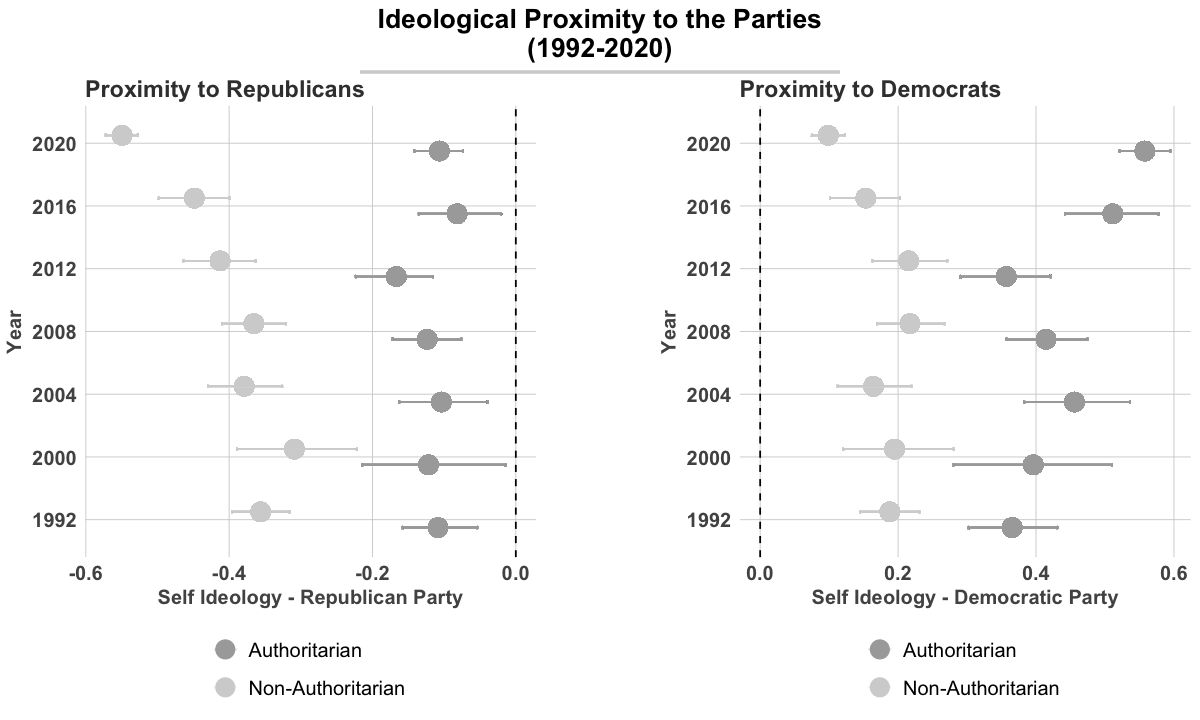

In [310]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggtheme <- theme(
   plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
   axis.text.x = element_text(size = 12, colour = "#535353", face = "bold"),
   axis.text.y = element_text(size = 12, colour = "#535353", face = "bold"),
   axis.title = element_text(size = 12, colour = "#535353", face = "bold"),
   axis.title.y = element_text(size = 12, colour = "#535353", face = "bold", vjust = 1.5),
   axis.ticks = element_blank(),
   strip.text.x = element_text(size = 12),
   panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
   panel.background = element_rect(fill = "white"),
   legend.text = element_text(size = 12),
   legend.title = element_text(size = 16)
)


plotting_data = ch8models [["filteredData"]] %>%
   select(differenceR1, differenceD1, authoritarianism, female, age, college, income, jewish, catholic, other, year) %>%
   na.omit() %>%
   group_by(year) %>%
   data_grid(female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), authoritarianism = seq_range(authoritarianism, n = 2)) %>%
   mutate(authoritarianism2 = authoritarianism * authoritarianism)

a = plotting_data  %>%
  add_linpred_draws(ch8models [["distanceRep"]])   %>%
  mutate(probability = .linpred) %>%
  group_by(authoritarianism, year) %>%
  mutate(min = quantile(probability, 0.025)) %>%
  mutate(med = quantile(probability, 0.50)) %>%
  mutate(max = quantile(probability, 0.975)) %>%
  mutate(Authoritarianism = ifelse(authoritarianism == 1, "Authoritarian", "Non-Authoritarian")) %>%
  ggplot(aes(x = factor(year), y = med, ymin = min, ymax = max, colour = Authoritarianism, group = Authoritarianism)) +
  geom_point(size = 5, alpha = 1, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.3, position = position_dodge(width = 0.5)) +
  ggtitle("Proximity to Republicans")  +
  ylab("Self Ideology - Republican Party") +
  xlab("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed")  +
  coord_flip() +
  scale_colour_manual(name = "", values = c("darkgrey", "lightgrey")) +
  ggtheme  +
theme(legend.position = "bottom")   +
 guides(color = guide_legend(nrow = 2, byrow = TRUE)) +
theme(legend.title = element_blank()) +
theme(plot.title = element_text(size = 14, lineheight = 0.9)) +
   theme(legend.text = element_text(size = 12))



b = plotting_data  %>%
   add_linpred_draws(ch8models [["distanceDem"]]) %>%
   mutate(probability = .linpred) %>%
   group_by(authoritarianism, year) %>%
   mutate(min = quantile(probability, 0.025)) %>%
   mutate(med = quantile(probability, 0.50)) %>%
   mutate(max = quantile(probability, 0.975)) %>%
   mutate(Authoritarianism = ifelse(authoritarianism == 1, "Authoritarian", "Non-Authoritarian")) %>%
   ggplot(aes(x = factor(year), y = med, ymin = min, ymax = max, colour = Authoritarianism,  group = Authoritarianism)) +
   geom_point(size = 5,, alpha = 1, position = position_dodge(width = 0.5)) +
   geom_errorbar(width = 0.10, alpha = 0.3, position = position_dodge(width = 0.5)) +
   ggtitle("Proximity to Democrats") +
   ylab("Self Ideology - Democratic Party") +
   xlab("Year") +
   geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
   coord_flip() +
   scale_colour_manual("", values = c("darkgrey", "lightgrey")) +
   ggtheme +
   theme(legend.position = "bottom")  +
    guides(color = guide_legend(nrow = 2, byrow = TRUE))  +
      theme(legend.title = element_blank()) +
      theme(plot.title = element_text(size = 14, lineheight = 0.9)) +
      theme(legend.text = element_text(size = 12))



# Combine the plots
combined_plot <- plot_grid(a, NULL, b, nrow = 1,  ncol = 3,  rel_widths = c(1, .2, 1))

combined_plot <- ggdraw(combined_plot) +
   draw_line(x = c(0.3, 0.7), y = c(0.99, 0.99), color = "lightgrey", size = 1)


# Add the main title
main_title <- ggdraw() +
   draw_label("Ideological Proximity to the Parties\n(1992-2020)", fontface = "bold", size = 16, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
   ncol = 1,
   rel_heights = c(.1, 1)
)

final_plot

In [318]:
plotting_data %>%
  add_linpred_draws(ch8models[["distanceDem"]]) %>%
  mutate(probability = .linpred) %>%
  group_by(year, authoritarianism) %>%
  summarize(
    min = quantile(.linpred, 0.025),
    med = quantile(.linpred, 0.50),
    max = quantile(.linpred, 0.975))

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year,authoritarianism,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1992,0,0.14474660,0.18804401,0.2311178
1992,1,0.30165050,0.36536490,0.4307378
2000,0,0.12035841,0.19481067,0.2805062
2000,1,0.28020175,0.39599884,0.5099901
2004,0,0.11231352,0.16424889,0.2193473
2004,1,0.38288177,0.45575293,0.5363764
2008,0,0.16972520,0.21722442,0.2672701
2008,1,0.35740657,0.41448513,0.4746516
2012,0,0.16274825,0.21532759,0.2713540


In [227]:
ch8models[["distanceRep"]]$data %>% dim()
ch8models[["distanceDem"]]$data %>% dim()


[1] 5950   11

[1] 5950   11

In [319]:
cat("The Republican Predictions Are")
ch8models[["filteredData"]] %>%
   select(differenceR1, differenceD1, authoritarianism, female, age, college, income, jewish, catholic, other, year) %>%
   na.omit() %>%
   group_by(year) %>%
   data_grid(female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), authoritarianism = seq_range(authoritarianism, n = 2)) %>%
   mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
   add_linpred_draws(ch8models[["distanceRep"]]) %>%
   mutate(probability = .linpred) %>%
   group_by(authoritarianism, year) %>%
   summarize(
   med = quantile(probability, 0.5)) %>%
   mutate(Authoritarianism = ifelse(authoritarianism == 1, "Authoritarian", "Non-Authoritarian"))



The Republican Predictions Are

`summarise()` has grouped output by 'authoritarianism'. You can override using
the `.groups` argument.


authoritarianism,year,med,Authoritarianism
<dbl>,<dbl>,<dbl>,<chr>
0,1992,-0.35605137,Non-Authoritarian
0,2000,-0.30887003,Non-Authoritarian
0,2004,-0.37888512,Non-Authoritarian
0,2008,-0.36545752,Non-Authoritarian
0,2012,-0.41265712,Non-Authoritarian
0,2016,-0.44843427,Non-Authoritarian
0,2020,-0.54935091,Non-Authoritarian
1,1992,-0.10854788,Authoritarian
1,2000,-0.12181994,Authoritarian


In [235]:
cat("The Democratic Predictions Are")
ch8models[["filteredData"]] %>%
  select(differenceR1, differenceD1, authoritarianism, female, age, college, income, jewish, catholic, other, year) %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), authoritarianism = seq_range(authoritarianism, n = 2)) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch8models[["distanceDem"]]) %>%
  mutate(probability = .linpred) %>%
  group_by(authoritarianism, year) %>%
  summarize(
    med = quantile(probability, 0.5)
  ) %>%
  mutate(Authoritarianism = ifelse(authoritarianism == 1, "Authoritarian", "Non-Authoritarian"))


The Democratic Predictions Are

`summarise()` has grouped output by 'authoritarianism'. You can override using
the `.groups` argument.


authoritarianism,year,med,Authoritarianism
<dbl>,<dbl>,<dbl>,<chr>
0,1992,0.18804401,Non-Authoritarian
0,2000,0.19481067,Non-Authoritarian
0,2004,0.16424889,Non-Authoritarian
0,2008,0.21722442,Non-Authoritarian
0,2012,0.21532759,Non-Authoritarian
0,2016,0.15321466,Non-Authoritarian
0,2020,0.09880157,Non-Authoritarian
1,1992,0.36536490,Authoritarian
1,2000,0.39599884,Authoritarian


In [149]:
formula(ch8add[["modelFit"]])

vote ~ authoritarianism + authoritarianism2 + diffCR + diffCD + authoritarianism * diffCR + authoritarianism2 * diffCR + authoritarianism * diffCD + authoritarianism2 * diffCD + female + age + college + income + jewish + catholic + other + (1 + authoritarianism + authoritarianism2 + diffCR + diffCD + authoritarianism * diffCR + authoritarianism2 * diffCR + authoritarianism * diffCD + authoritarianism2 * diffCD | year) 

# The Spatial Model

These are the models with a Euclidean distance measure of ideological proximity.

The spatial effects for each comparison is shown, aligned with one party. Below we show the spatial effects for each party, aligned with the other party. This isn't currently in the chapter, but useful for contextualizing things.

In [282]:
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/Chapter Analysis/Chapter 8 Analysis/spatialModel.rda")

spatial_dat <- ch8models[["filteredData"]] %>%
   mutate(diffCR = differenceR * differenceR) %>%
    mutate(diffCD = differenceD * differenceD) %>%
    mutate(diffOfdiff = diffCD - diffCR) %>%
  select(vote, diffCR, diffCD, authoritarianism, authoritarianism2, female, age, college, income, jewish, catholic, other, year, diffOfdiff) %>%
  na.omit()



`summarise()` has grouped output by 'authoritarianism', 'year'. You can
override using the `.groups` argument.


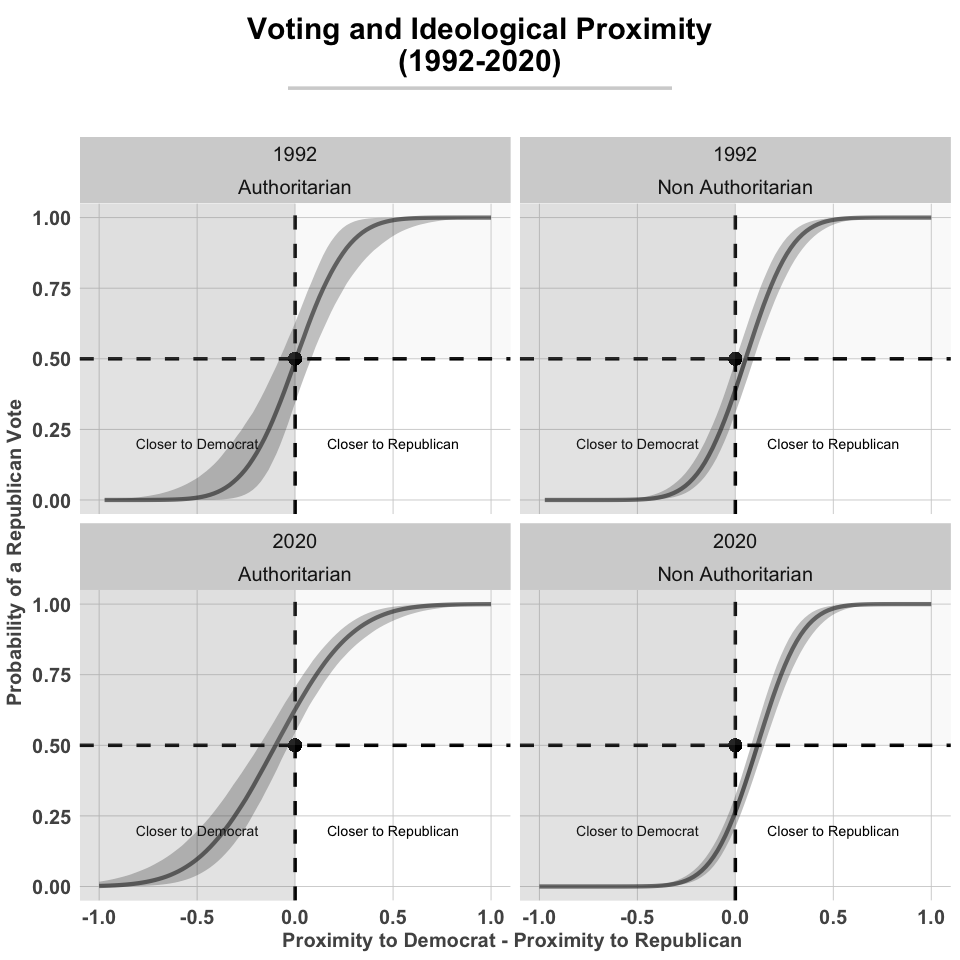

In [321]:
options(repr.plot.width = 8, repr.plot.height = 8)

library(dplyr)
library(brms)
library(modelr)
library(dplyr)
library(modelr)
library(tidybayes)
library(haven)
library(ggplot2)
library(dplyr)
library(cowplot)


ch8models[["filteredData"]] %>%
  group_by(year) %>%
  mutate(differenceR = ideology - ideologyCR) %>%
  mutate(differenceD = ideology - ideologyCD) %>%
  mutate(diffCR = differenceR * differenceR) %>%
  mutate(diffCD = differenceD * differenceD) %>%
  mutate(diffOfdiff = diffCD - diffCR) %>%
  data_grid(
    diffOfdiff = seq_range(diffOfdiff, 100),
    authoritarianism = seq_range(authoritarianism, n = 2),
    female = mean(female, na.rm = TRUE), age = mean(age, na.rm = TRUE), college = mean(college, na.rm = TRUE), income = mean(income, na.rm =TRUE), catholic = mean(catholic, na.rm  = TRUE), jewish = mean(jewish, na.rm  = TRUE), other = mean(other, na.rm = TRUE)
  )   %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(my_list[["model"]]) %>%
  mutate(probability = .epred) %>%
  group_by(authoritarianism, year, diffOfdiff) %>%
  filter(year ==1992 | year == 2020) %>%
  summarize(
    mean = quantile(probability, prob = 0.5),
    min = quantile(probability, prob = 0.025),
    max = quantile(probability, prob = 0.975)
  ) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
  ggplot(aes(ymin = min, ymax = max, x = diffOfdiff, y = mean)) +
  facet_wrap(~   year + Authoritarianism, ncol = 2) +
  geom_line(size = 1.2, alpha = 0.60) +
  geom_ribbon(alpha = 0.3) +
  ggtitle("") +
  ylab("Probability of a Republican Vote") +
  xlab("Year") +
  ggtheme +
  theme(plot.caption = element_text(hjust = 0)) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "black", size = 1) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", size = 1) +
  geom_point(aes(x = 0, y = 0.5), size = 3, color = "black") +
  xlab("Proximity to Democrat - Proximity to Republican ") +
  annotate("rect", xmin = -Inf, xmax = 0, ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "black") +
  annotate("text", x = -0.5, y = 0.2, label = "Closer to Democrat", size = 3, color = "black") +
  # shade everything to the left of the vertical line, light gray
  annotate("rect", xmin = -Inf, xmax = 0, ymin = -Inf, ymax = Inf, alpha = 0.1, fill = "lightgrey") +
  # label the shaded area "Closer to Democratic Candidate"
  annotate("text", x = 0.5, y = 0.2, label = "Closer to Republican", size = 3, color = "black") +
  # color everything above 0.5 as light red
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.5, ymax = Inf, alpha = 0.1, fill = "lightgrey") +
  theme(strip.background = element_rect(fill = "lightgrey")) -> p1

# Combine the plots
combined_plot <- plot_grid(p1, nrow = 1, ncol = 1)

combined_plot <- ggdraw(combined_plot) +
  draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)


# Add the main title
main_title <- ggdraw() +
  draw_label("Voting and Ideological Proximity\n(1992-2020)", fontface = "bold", size = 18, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
  ncol = 1,
  rel_heights = c(.1, 1)
)

final_plot

In [ ]:
ch8models[["filteredData"]] %>%
  group_by(year) %>%
  mutate(differenceR = ideology - ideologyCR) %>%
  mutate(differenceD = ideology - ideologyCD) %>%
  mutate(diffCR = differenceR * differenceR) %>%
  mutate(diffCD = differenceD * differenceD) %>%
  mutate(diffOfdiff = diffCD - diffCR) %>%
  data_grid(
    diffOfdiff = 0,
    authoritarianism = seq_range(authoritarianism, n = 2),
    female = mean(female, na.rm = TRUE), age = mean(age, na.rm = TRUE), college = mean(college, na.rm = TRUE), income = mean(income, na.rm = TRUE), catholic = mean(catholic, na.rm = TRUE), jewish = mean(jewish, na.rm = TRUE), other = mean(other, na.rm = TRUE)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(my_list[["model"]]) %>%
  mutate(probability = .epred) %>%
  group_by(authoritarianism, year, diffOfdiff) %>%
  filter(year == 1992 | year == 2020) %>%
  summarize(
    mean = quantile(probability, prob = 0.5),,
  )
  # Change scientific notation
  options(scipen = 999)

`summarise()` has grouped output by 'authoritarianism', 'year'. You can
override using the `.groups` argument.


authoritarianism,year,diffOfdiff,mean
<dbl>,<dbl>,<dbl>,<dbl>
0,1992,0,0.3889582
0,2020,0,0.2641662
1,1992,0,0.4904976
1,2020,0,0.6263469


In [326]:
options(repr.plot.width = 13, repr.plot.height = 12)

ch8models[["filteredData"]] %>%
  group_by(year) %>%
  mutate(differenceR = ideology - ideologyCR) %>%
  mutate(differenceD = ideology - ideologyCD) %>%
  mutate(diffCR = differenceR * differenceR) %>%
  mutate(diffCD = differenceD * differenceD) %>%
  mutate(diffOfdiff = diffCD - diffCR) %>%
group_by(year) %>%
  data_grid(
    diffOfdiff = 0,
    authoritarianism = seq_range(authoritarianism, n = 2),
    female = mean(female, na.rm = TRUE), age = mean(age, na.rm = TRUE), college = mean(college, na.rm = TRUE), income = mean(income, na.rm = TRUE), catholic = mean(catholic, na.rm = TRUE), jewish = mean(jewish, na.rm = TRUE), other = mean(other, na.rm = TRUE)) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(my_list[["model"]]) %>%
 group_by(year, authoritarianism) %>%
  summarize(
    mean = quantile(.epred - 0.5, prob = 0.5),
    min = quantile(.epred - 0.5, prob = 0.025),
    max = quantile(.epred - 0.5, prob = 0.975)
  )



`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year,authoritarianism,mean,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1992,0,-0.11104183,-0.19176107,-0.00909220
1992,1,-0.00950244,-0.15401708,0.12747100
2000,0,-0.17175570,-0.27667505,-0.04670885
2000,1,0.06461138,-0.16165992,0.25926212
2004,0,-0.04892950,-0.15958611,0.07972977
2004,1,0.16729746,0.01327834,0.29292382
2008,0,-0.15423080,-0.23465350,-0.06127819
2008,1,0.07511258,-0.05392056,0.19278871
2012,0,-0.18044142,-0.26807847,-0.08455872


In [308]:
ch8models[["spatialModel"]]$data %>% dim()

[1] 4668   12

Here is a function to return estimated predictions.

In [336]:
predict_term <- function(model = my_list[["model"]], group = "Authoritarian") {
  intercept <- model %>%
    spread_draws(b_Intercept, b_authoritarianism, b_authoritarianism2, r_year[year, term])

  slopes <- model %>% spread_draws(b_diffOfdiff, `b_authoritarianism:diffOfdiff`, `b_authoritarianism2:diffOfdiff`, r_year[year, term])


  if (group == "Authoritarian") {
    # The intercepts for authoritarians
    intercept <- intercept %>%
      filter(term == "Intercept" | term == "authoritarianism" | term == "authoritarianism2") %>%
      group_by(.chain, .iteration, .draw, year) %>%
      mutate(re_sum = sum(r_year)) %>%
      filter(term == "Intercept") %>%
      group_by(year) %>%
      mutate(intercept_term = `b_Intercept` + `b_authoritarianism` + `b_authoritarianism2` + re_sum)
    slopes <- slopes %>%
      filter(term == "diffOfdiff" | term == "authoritarianism:diffOfdiff" | term == "authoritarianism2:diffOfdiff") %>%
      group_by(.chain, .iteration, .draw, year) %>%
      mutate(re_sum = sum(r_year)) %>%
      filter(term == "diffOfdiff") %>%
      mutate(slope = `b_diffOfdiff` + `b_authoritarianism:diffOfdiff` + `b_authoritarianism2:diffOfdiff` + re_sum)
  } else {
    intercept <- intercept %>%
      filter(term == "Intercept") %>%
      group_by(.chain, .iteration, .draw, year) %>%
      mutate(re_sum = sum(r_year)) %>%
      filter(term == "Intercept") %>%
      group_by(year) %>%
      mutate(intercept_term = `b_Intercept` + re_sum)
    slopes <- slopes %>%
      filter(term == "diffOfdiff") %>%
      group_by(.chain, .iteration, .draw, year) %>%
      mutate(re_sum = sum(r_year)) %>%
      mutate(slope = `b_diffOfdiff` + re_sum)
  }

  prediction <- subset(intercept, select = c(year, intercept_term))
  prediction$slope <- slopes$slope
  prediction$point <- prediction$intercept_term / prediction$slope * -1
  prediction <- prediction %>%
    group_by(year) %>%
    summarize(mean = mean(point), high = quantile(point, 0.975), low = quantile(point, 0.025))

  return(prediction)
}
predict_term(group = "Authoritarian")


year,mean,high,low
<int>,<dbl>,<dbl>,<dbl>
1992,-0.01712541,0.06462787,-0.1109352
2000,-0.09434784,0.07840969,-0.3934285
2004,-0.14815107,-0.02615517,-0.3313029
2008,-0.08855893,0.02009967,-0.2264348
2012,-0.08435383,0.00229286,-0.2048741
2016,-0.15675123,-0.03839950,-0.3507009
2020,-0.13563749,-0.04976082,-0.2397769


In [ ]:
return_predictions = function(repValue, demValue){
plot_dat <- spatial_dat %>%
  group_by(year) %>%
  data_grid(
    diffCD = demValue,
    diffCR = repValue,
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch9models[["modelFit"]]) %>%
  mutate(probability = pnorm(.linpred)) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
  group_by(diffCD, diffCR, year, Authoritarianism) %>%
  summarize(
    probability = quantile(probability, prob = 0.5),
    max = quantile(probability, prob = 0.975),
    min = quantile(probability, prob = 0.025)
  )
  return(plot_dat)
}
return_predictions(1,1)

We may choose not to present all this, but it might still be useful in constructing our narrative. The place to start with a spatial model is to first examine trends over time, particularly since the ideology of the respondent, and perceptions may change over time. 

# The Consequences of Polarization




In [154]:
spatial_dat <- ch8models[["filteredData"]] %>%
    filter(ideologyR >= ideologyD) %>%
    select(vote, ideology, ideologyD, ideologyR,  authoritarianism, authoritarianism2, female, age, college, income, jewish, catholic, other, year) %>%
    na.omit() %>%
    mutate(polarization = (ideologyR - ideologyD) )


    range(spatial_dat$polarization)

[1] 0 1

In [161]:
options(repr.plot.width = 15, repr.plot.height = 10)

spatial_dat %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), ideology = mean(ideology),
    polarization = seq_range(polarization, n = 2  ),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch8models[["polarizationMod"]]) %>%
  mutate(probability = pnorm(.linpred)) %>%
  # group_by(diffCD, diffCR, year, authoritarianism) %>%
  # summarize(
  #   mean = quantile(probability, prob = 0.5),
  #   min = quantile(probability, prob = 0.025),
  #   max = quantile(probability, prob = 0.975)
  # ) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
    mutate(polarization = ifelse(polarization == 0, "No Perceived Polarization", "Maximum Perceived Polarization")) %>%
    # relevell the polarization variable
    mutate(polarization = factor(polarization, levels = c("No Perceived Polarization", "Maximum Perceived Polarization"))) %>%




  ggplot(aes(x =as.factor( year), y = probability, colour = Authoritarianism)) +
    facet_wrap(~polarization, scales = "free", nrow =1) +
    stat_summary(fun = median, geom = "point", shape = 20, size = 5,  position = position_dodge(width = 0.5)) +
    ggtheme +
    geom_point(size = 2, alpha = 0.05, shape = 18,  position = position_dodge(width = 0.5)) +
    ggtitle("A. Predictive Effects") +
    theme(legend.key = element_blank()) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(y = "Probability of a Republican Vote", x = "Polarization") +
    scale_color_manual("", values = c("grey", "black")) +
    geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed") +
     theme(legend.position = "top") +
     scale_x_discrete("Year") +
     guides(color = guide_legend(nrow = 2, byrow = TRUE)) -> p1



In [158]:
spatial_dat %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), ideology = mean(ideology),
    polarization = seq_range(polarization, n = 2   ),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch8models[["polarizationMod"]]) %>%
  mutate(probability = pnorm(.linpred)) %>%
  group_by(polarization, year, authoritarianism) %>%
  summarize(
    mean = quantile(probability, prob = 0.5),
    min = quantile(probability, prob = 0.025),
    max = quantile(probability, prob = 0.975)
  ) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian"))


`summarise()` has grouped output by 'polarization', 'year'. You can override
using the `.groups` argument.


polarization,year,authoritarianism,mean,min,max,Authoritarianism
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,1992,0,0.4480056,0.21345447,0.6956837,Non Authoritarian
0,1992,1,0.3931497,0.11747898,0.6874195,Authoritarian
0,2000,0,0.3042747,0.10257897,0.6221532,Non Authoritarian
0,2000,1,0.5514935,0.11252512,0.9205632,Authoritarian
0,2004,0,0.6148061,0.34918371,0.8330336,Non Authoritarian
0,2004,1,0.7626190,0.37611795,0.9599004,Authoritarian
0,2008,0,0.6233172,0.33040720,0.8361534,Non Authoritarian
0,2008,1,0.8108904,0.50901504,0.9693105,Authoritarian
0,2012,0,0.4018848,0.16181442,0.6790015,Non Authoritarian


In [160]:
ch8models[["polarizationMod"]]$data %>% dim()


[1] 4775   13

`summarise()` has grouped output by 'polarization'. You can override using the
`.groups` argument.


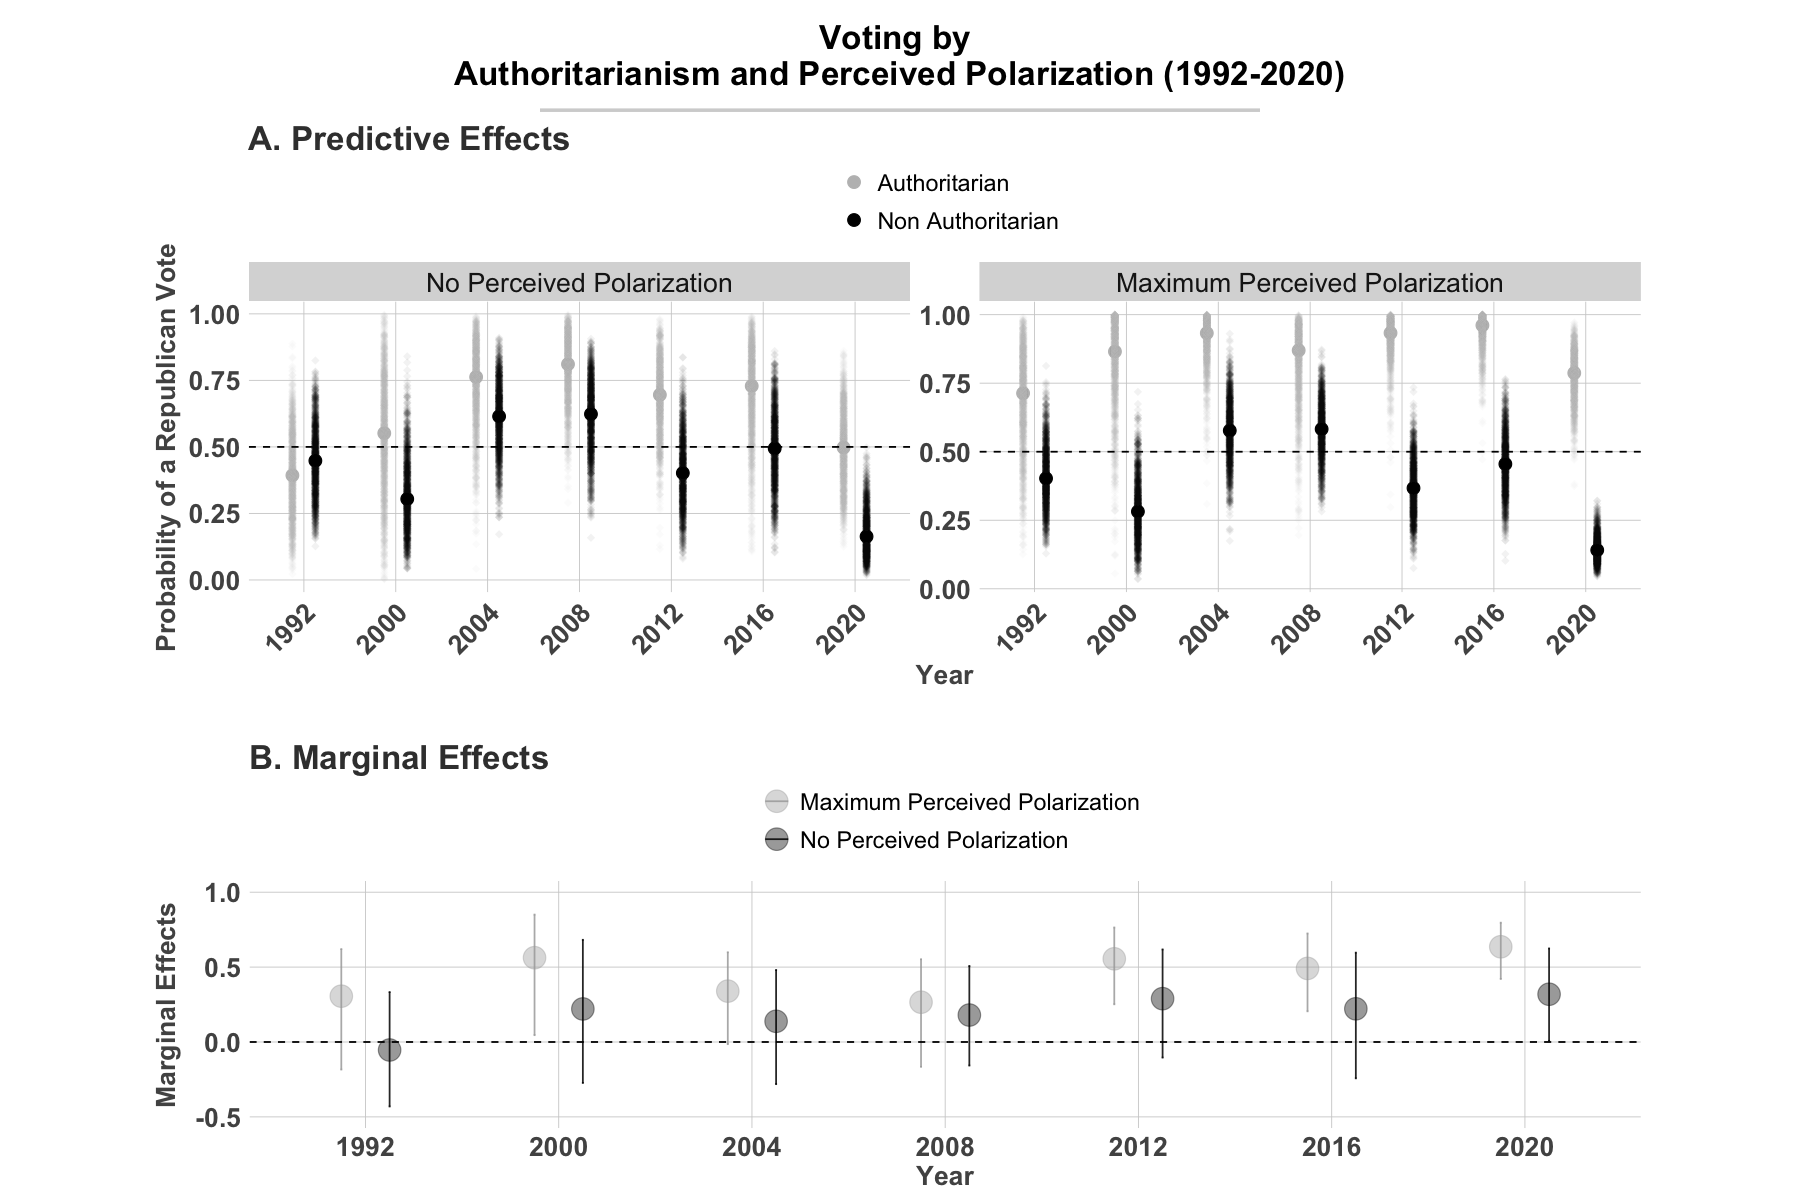

In [162]:
options(repr.plot.width = 15, repr.plot.height = 10)

a = spatial_dat %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other),ideology = mean(ideology),
    polarization = seq_range(polarization, n = 2 ),
    authoritarianism = 1
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch8models[["polarizationMod"]]) %>%
  mutate(probability = pnorm(.linpred)) %>%
    mutate(polarization = ifelse(polarization == 0, "No Perceived Polarization", "Maximum Perceived Polarization"))



b = spatial_dat %>%
   group_by(year) %>%
   data_grid(
     female = mean(female), age = mean(age), college = mean(college), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), ideology = mean(ideology),
     polarization = seq_range(polarization, n = 2),
     authoritarianism = 0
   ) %>%
   mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch8models[["polarizationMod"]]) %>%
   mutate(probability = pnorm(.linpred)) %>%
  mutate(polarization = ifelse(polarization == 0, "No Perceived Polarization", "Maximum Perceived Polarization"))


difference <- a$probability - b$probability
a$difference <- difference

a %>%
  group_by(polarization, year) %>%
  summarize(
    mean = quantile(difference, prob = 0.5),
    min = quantile(difference, prob = 0.025),
    max = quantile(difference, prob = 0.975)
  ) %>%
   ggplot(aes(
     x = as.factor(year),
     y = mean, ymin = min,
     ymax = max,
     color = as.factor(polarization)
   )) +
     geom_point(size = 6, alpha = 0.4, position = position_dodge(width = 0.5)) +
     geom_errorbar(width = 0.02, alpha = 0.85, position = position_dodge(width = 0.5)) +
     ggtitle("B. Marginal Effects") +
     ggtheme +
     scale_y_continuous("Marginal Effects", limits = c(-0.5, 1)) +
     geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
   scale_colour_manual(name = "", values = c("darkgrey", "black")) +
 theme(legend.position = "top") +
 scale_x_discrete("Year") +
guides(color = guide_legend(nrow = 2,  byrow = TRUE)) -> p2

# Combine the plots with padding
combined_plot <- plot_grid(
  plot_grid(NULL, p1, NULL, ncol = 3, rel_widths = c(0.1, 1, 0.1)),
  NULL,
  plot_grid(NULL, p2, NULL, ncol = 3, rel_widths = c(0.1, 1, 0.1)),
  ncol = 1,
  rel_heights = c(1, 0.05, 0.8)
)

# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
  draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
  draw_label("Voting by \nAuthoritarianism and Perceived Polarization (1992-2020)", fontface = "bold", size = 20, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
  ncol = 1,
  rel_heights = c(0.1, 1)
)

final_plot

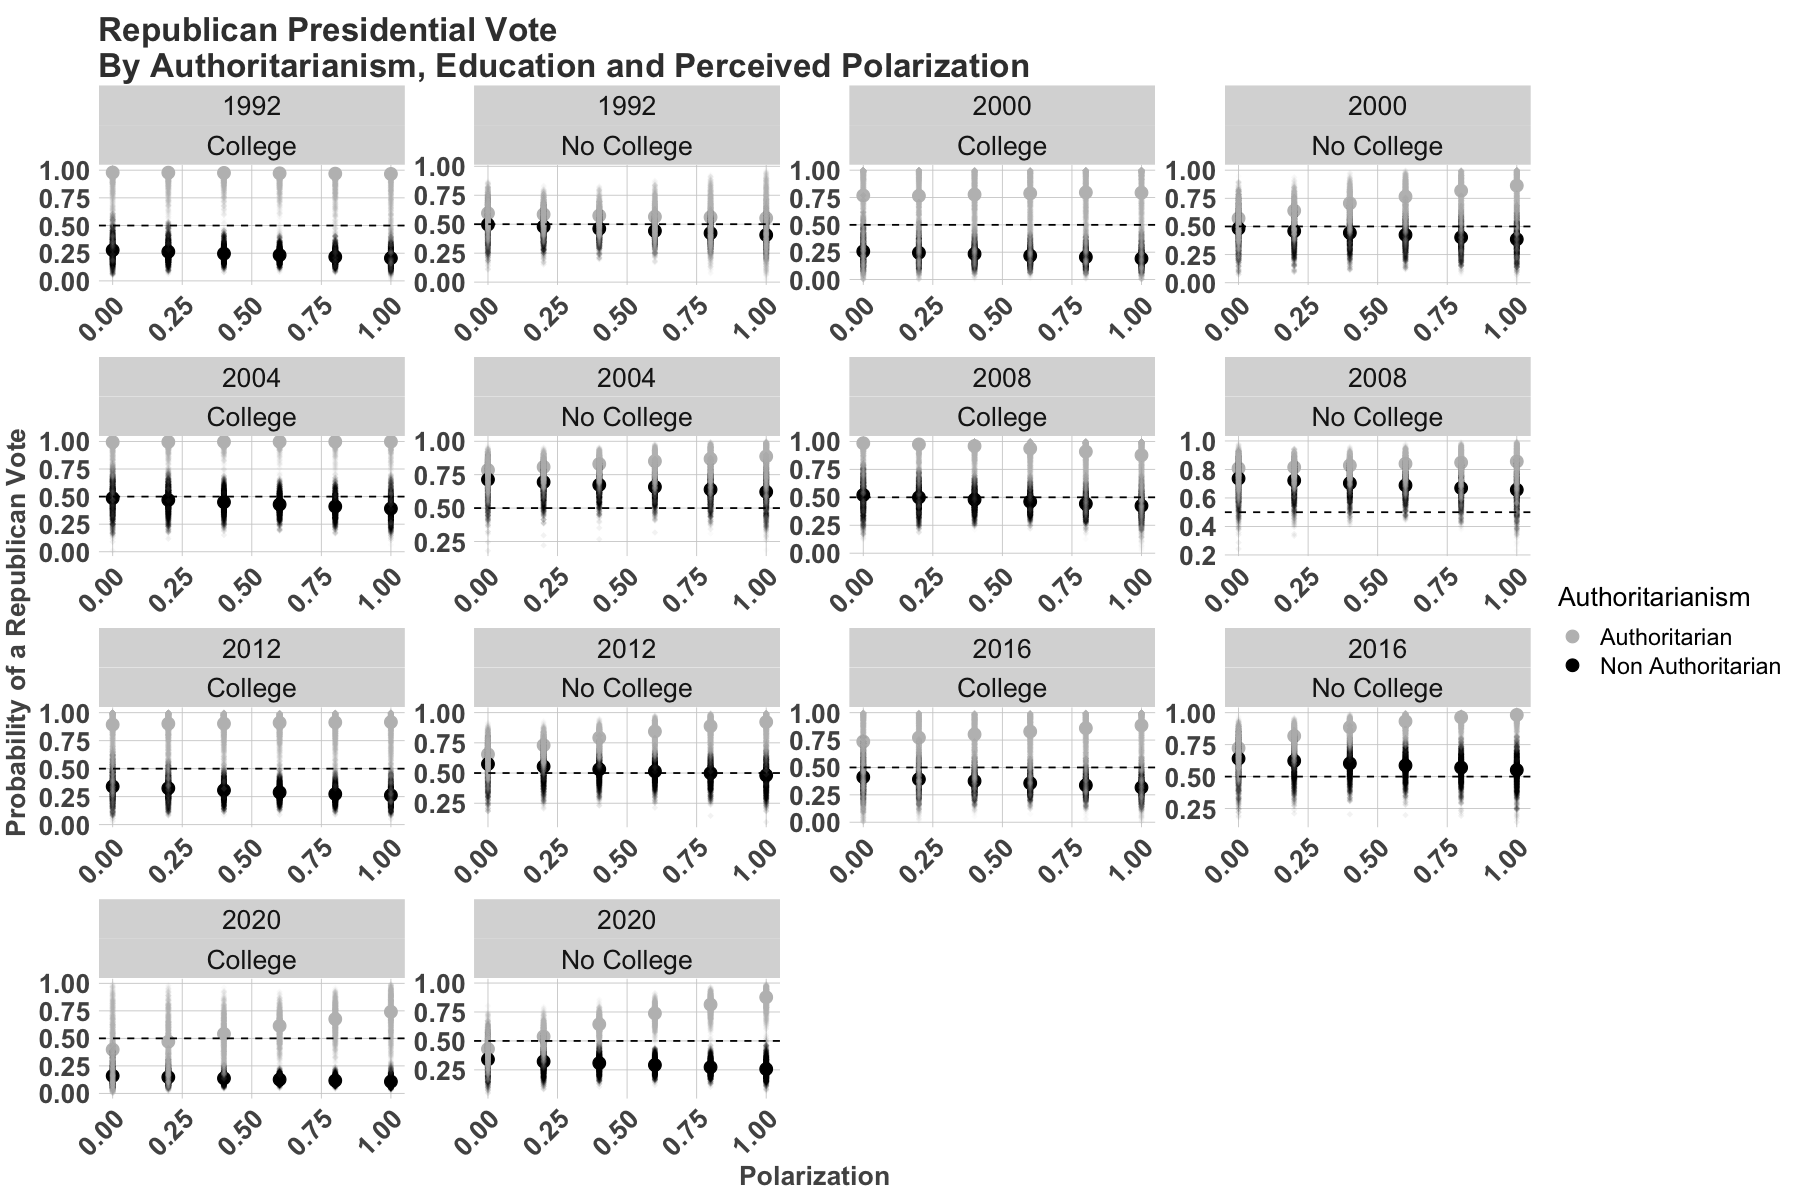

In [438]:
options(repr.plot.width = 15, repr.plot.height = 10)

spatial_dat %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age), college = c(0,1), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), ideology = mean(ideology),
    polarization = seq_range(polarization, n = 6),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch9models[["modelEducPolarization"]]) %>%
  mutate(probability = pnorm(.linpred)) %>%
  mutate("Authoritarianism" = ifelse(authoritarianism == 0, "Non Authoritarian", "Authoritarian")) %>%
  mutate(College = ifelse(college == 0, "No College", "College")) %>%

  ggplot(aes(x = polarization, y = probability, colour = Authoritarianism)) +
  facet_wrap(~year + College, scales = "free") +
  stat_summary(fun = median, geom = "point", shape = 20, size = 5) +
  ggtheme +
  geom_point(size = 1.5, alpha = 0.05, shape = 18) +
  ggtitle("Republican Presidential Vote\nBy Authoritarianism, Education and Perceived Polarization") +
  theme(legend.key = element_blank()) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(y = "Probability of a Republican Vote", x = "Polarization") +
  scale_color_manual(values = c("grey", "black")) +
  geom_hline(yintercept = 0.5, colour = "black", linetype = "dashed")

In [ ]:
a <- spatial_dat %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age), college = c(0,1), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), ideology = mean(ideology),
    polarization = seq_range(polarization, n = 6),
    authoritarianism = 1
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch9models[["modelEducPolarization"]]) %>%
  mutate(probability = pnorm(.linpred))


b <- spatial_dat %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age), college =c(0,1), income = mean(income), catholic = mean(catholic), jewish = mean(jewish), other = mean(other), ideology = mean(ideology),
    polarization = seq_range(polarization, n = 6),
    authoritarianism = 0
  ) %>%
  mutate(authoritarianism2 = authoritarianism * authoritarianism) %>%
  add_linpred_draws(ch9models[["modelEducPolarization"]]) %>%
  mutate(probability = pnorm(.linpred))
difference <- a$probability - b$probability
a$difference <- difference
a$College = ifelse(a$college == 0, "No College", "College")

a %>%
  group_by(polarization, authoritarianism, College, year) %>%
  summarize(
    mean = quantile(difference, prob = 0.5),
    min = quantile(difference, prob = 0.025),
    max = quantile(difference, prob = 0.975)
  ) %>%
  ggplot(aes(
    x = polarization,
    y = mean, ymin = min,
    ymax = max,
  )) +
  facet_wrap(~year + College) +
  geom_point(size = 6, alpha = 0.75, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.02, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Marginal Effect of Authoritarianism,\nBy Perceived Polarization, Education") +
  ggtheme +
  scale_y_continuous("Marginal Effect of Authoritarianism", limits = c(-0.5, 1)) +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "College", values = c("darkgrey", "black")) +
  labs(x = "Polarization")